In [1]:
from src.data import DataLoaders
from src import utils
import pathlib
import pandas as pd
from src.models.ModelClasses import FireRiskModels, SmokeAlarmModels
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
ACS =  DataLoaders.ACSData(2016,'block_group')

In [3]:
NFIRS = DataLoaders.NFIRSData('block_group',ACS.tot_pop)
NFIRS_Sev = DataLoaders.NFIRSData('block_group',ACS.tot_pop,sev=True)

/home/kelsonss/anaconda3/envs/rcp2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
ACS_cols_to_use =[ 'did_not_work_past_12_mo',
               'house_pct_live_alone',
               'pct_alt_heat',
               'house_yr_pct_before_1960',
               'inc_pct_poverty',
               'race_pct_black_or_amind']

In [5]:
FSM =  FireRiskModels('severity')
FPM =  FireRiskModels('propensity')

In [6]:
FPM.train(NFIRS,ACS,ACS_cols_to_use)

/home/kelsonss/Documents/GitHub/rcp2/src/models/ModelClasses.py:171: RuntimeWarning: All-NaN axis encountered
  mx = np.nanmax(X, axis =1)
/home/kelsonss/anaconda3/envs/rcp2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/kelsonss/Documents/GitHub/rcp2/src/models/ModelClasses.py:218: RuntimeWarning: All-NaN axis encountered
  mx = np.nanmax(X, axis =1)


213144
202783
Predicting 2017:
Feature ranking:
1. Max (0.385028)
2. Median (0.154249)
3. pct_alt_heat (0.088281)
4. house_pct_live_alone (0.079518)
5. race_pct_black_or_amind (0.075907)
6. house_yr_pct_before_1960 (0.073211)
7. inc_pct_poverty (0.072736)
8. did_not_work_past_12_mo (0.071069)


In [7]:
FSM.train(NFIRS_Sev,ACS,ACS_cols_to_use)

213144
202783
Predicting 2017:
Feature ranking:
1. Median (0.313726)
2. Max (0.212111)
3. did_not_work_past_12_mo (0.082153)
4. race_pct_black_or_amind (0.080522)
5. pct_alt_heat (0.079632)
6. house_yr_pct_before_1960 (0.078414)
7. inc_pct_poverty (0.077514)
8. house_pct_live_alone (0.075928)


In [8]:
ARC =  DataLoaders.ARCPData()

In [9]:
ARC.data

,geoid,census_block_group_y,census_block_group_x,city,state,zip,county,in_home_visit_date,smoke_alarms_installed__9_volt_10_year_dhh_,10_year_and_9_volt_alarms_installed,...,batteries_replaced,fire_escape_plans_made,fire_safety_checklists_completed,additional_hazard_education_conducted,additional_hazard_type,people_served,youth_served,seniors_served,veterans_military_members_and_military_family_members_served,individuals_with_disabilities_access_or_functional_needs_served
12,010010205002,32.470418,-86.424166,PRATTVILLE,AL,36066,Autauga,9/9/2016,1,1,...,0,1,1,0,None,2,0,0,0,0
18,010010208012,32.455173,-86.534591,PRATTVILLE,AL,36067,Autauga,9/30/2019,2,2,...,0,1,1,1,Tornadoes,5,0,0,1,0
23,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,5/4/2019,3,2,...,0,1,1,1,Other,1,0,0,0,0
24,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,9/27/2019,1,1,...,0,1,1,1,Tornadoes,1,0,0,0,0
27,010010208023,32.543983,-86.492100,PRATTVILLE,AL,36067,Autauga,12/2/2017,3,3,...,0,1,1,0,None,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862041,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,2,2,...,0,1,1,1,Wildfires,1,0,0,0,0
862042,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,3,3,...,0,1,1,1,Wildfires,4,2,0,0,0
862043,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,3,3,...,0,1,1,1,Wildfires,2,0,1,0,1
862044,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,4,4,...,0,1,1,1,Wildfires,3,0,0,0,0


In [10]:
SV = pd.read_csv(Path.cwd() / "Data" / "Master Project Data"/"SVI Tract Data.csv")

In [11]:
SV.columns

Index(['GEOID', 'ST', 'STATE', 'ST_ABBR', 'COUNTY', 'LOCATION', 'AREA_SQMI',
       'E_TOTPOP', 'M_TOTPOP', 'E_HU',
       ...
       'F_CROWD', 'F_NOVEH', 'F_GROUPQ', 'F_THEME4', 'F_TOTAL', 'E_UNINSUR',
       'M_UNINSUR', 'EP_UNINSUR', 'MP_UNINSUR', 'E_DAYPOP'],
      dtype='object', length=123)

In [12]:
SVI =  DataLoaders.SVIData(ACS.data)
SVI.data

,inc_pct_poverty,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4
geos,,,,,
010010201001,0.191946,0.3913,0.5597,0.3735,0.0993
010010201002,0.044269,0.3913,0.5597,0.3735,0.0993
010010202001,0.382199,0.7065,0.3585,0.5821,0.7299
010010202002,0.111426,0.7065,0.3585,0.5821,0.7299
010010203001,0.042301,0.5659,0.8729,0.6429,0.3882
...,...,...,...,...,...
560459511001,0.094029,0.3925,0.6370,0.2331,0.8555
560459511002,0.062579,0.3925,0.6370,0.2331,0.8555
560459513001,0.261512,0.5093,0.6043,0.2862,0.6949


In [13]:
Smoke = SmokeAlarmModels()

-----Training_Performance------
62.8997317297679
Test RMSE: 7.930935110676918
Test MAE: 5.725675375525959


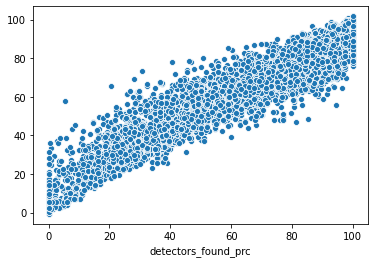

-----Test Performance ----- 
Test RMSE: 10.28287508598752
Test MAE: 7.452201758736219


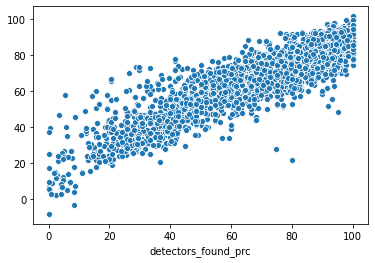

Test Correlation: (0.8883902077149819, 0.0)
Test R-squared: 0.7808540878900833

 Feature ranking:
1. county_detectors_found_prc (0.427048)
2. state_detectors_found_prc (0.209619)
3. RPL_THEME1 (0.086292)
4. RPL_THEME3 (0.078568)
5. RPL_THEME2 (0.072986)
6. RPL_THEME4 (0.061360)
7. Population Density (per square mile), 2010 (0.051668)
8. inc_pct_poverty (0.012460)


In [14]:
svi_use = True
smoke_prediction = Smoke.trainModels(ARC,ACS,SVI, ACS_cols_to_use,svi_use, utils.DATA['data'])

In [37]:
out = NFIRS.fires.copy()
out.columns =  'fires_per_1K_pop_' + out.columns
cols = out.columns

In [38]:
out = ACS.data.merge(out, how = 'left', left_index = True, right_index = True)
out = out[cols]

In [43]:
out.index.str[:2]

Index(['01', '01', '01', '01', '01', '01', '01', '01', '01', '01',
       ...
       '56', '56', '56', '56', '56', '56', '56', '56', '56', '56'],
      dtype='object', name='GEOID', length=213144)

In [41]:
out['SVI_Poverity_Score'] =  SVI.data['RPL_THEME1'].map(out.index.str[:-1])

TypeError: 'Index' object is not callable

In [40]:
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017
GEOID,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN
...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619


In [39]:
SVI.data['RPL_THEME1']

geos
010010201001    0.3913
010010201002    0.3913
010010202001    0.7065
010010202002    0.7065
010010203001    0.5659
                 ...  
560459511001    0.3925
560459511002    0.3925
560459513001    0.5093
560459513002    0.5093
560459513003    0.5093
Name: RPL_THEME1, Length: 213144, dtype: float64

In [17]:
out['fire_propensity_risk_score'] = FPM.test_prediction_probs[:,1]
out['fire_severity_risk_score'] = FSM.test_prediction_probs[:,1]


In [18]:
# Smoke Alarm model munging 


# add number of surveys recorded at the block level
num_surveys_block = Smoke.models['Block_Group']['num_surveys'].copy()
num_surveys_block.index = num_surveys_block.index.str[2:]


out['recorded_home_visits'] = num_surveys_block


# add the statistical model outputs 
Smoke_predicts = Smoke.models['MultiLevel'][
    [ 'detectors_working_prc','detectors_working_CI','geography']].copy()
Smoke_predicts.index = Smoke_predicts.index.str[2:]
out = out.merge(Smoke_predicts,how = 'left', left_index = True, right_index = True)

## add DL model to outputs
DL = pd.DataFrame(smoke_prediction['Population Density (per square mile), 2010'])
DL['detectors_predicted'] = smoke_prediction['Predictions'].copy()

out = out.merge(DL,how = 'left', left_index = True, right_index = True)

In [19]:
out['smoke_detector_risk_score'] =  1 - out['detectors_predicted'] / 100

In [36]:
out['CombinedRiskScore'] = out['fire_severity_risk_score']
+ out['fire_propensity_risk_score'] 
+ out['smoke_detector_risk_score'] / 3 

GEOID
010010201001    0.250780
010010201002    0.243815
010010202001    0.290021
010010202002    0.303213
010010203001    0.308679
                  ...   
560459511001    0.137378
560459511002    0.128761
560459513001    0.109793
560459513002    0.109793
560459513003    0.109793
Name: smoke_detector_risk_score, Length: 213144, dtype: float32

In [21]:
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,fire_propensity_risk_score,fire_severity_risk_score,recorded_home_visits,detectors_working_prc,detectors_working_CI,geography,"Population Density (per square mile), 2010",detectors_predicted,smoke_detector_risk_score,CombinedRiskScore
GEOID,,,,,,,,,,,,,,,,,,,
#_010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0.622548,0.506302,0.0,31.38,1.089020,state,504.8,21.858675,0.781413,278.093109
#_010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0.966579,0.824059,0.0,31.38,1.089020,state,504.8,23.524992,0.764750,276.426758
#_010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0.740453,0.082554,0.0,31.38,1.089020,state,1682.5,9.120106,0.908799,290.831665
#_010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0.853479,0.805192,0.0,31.38,1.089020,state,1682.5,8.935228,0.910648,291.016541
#_010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0.994841,0.996304,0.0,31.38,1.089020,state,1633.1,9.486031,0.905140,290.465729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#_560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0.652114,0.248441,0.0,38.90,3.199404,state,1.4,70.594833,0.294052,229.356934
#_560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0.592363,0.505123,0.0,38.90,3.199404,state,1.4,71.463287,0.285367,228.488495
#_560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,0.918188,0.485757,3.0,38.90,3.199404,state,91.0,73.112038,0.268880,226.839737


In [20]:
out.index = '#_' + out.index
out.to_csv(utils.DATA['model-outputs'] / 'CombinedModels.csv')

In [ ]:
# alternate risk score ideas 

#out['CombinedRiskScore'] = (out[["fire_severity_risk_score", "fire_propensity_risk_score"]].max(axis=1) + out['smoke_detector_risk_score'])*100